# Nonlinear Transport from the Quantum Metric -- Berry Curvature Polarizability 

In [2]:
using LinearAlgebra;
using StaticArrays;
using Makie
using CairoMakie
using Printf


In [16]:
global const νF::Float64 = 1.0; 


In [33]:
# Here, we first define the necessary functions for the Dirac Fermion Hamiltonian, and the velocity matrices 
function eigensystem_dirac_fermion(k::Vector{Float64}, νt::Float64, Δ::Float64, νF::Float64 = νF)
    """
    Returns the eigenvalues and eigenvectors of the Dirac Fermion Hamiltonian
    Parameters: 
        k : momentum (More precisely, the wave-vector)
        νt: Tilt 
        Δ : Gap (Breaks inversion)
    """
    kz = νF * (-im * k[1] - k[2]); kzc = νF * (im * k[1] - k[2])
    eigen([Δ+νt*k[2] kz; kzc -Δ+νt*k[2]])
end



function evals(k::Vector{Float64}, νt::Float64, Δ::Float64, νF::Float64 = νF)
    """
    Returns the eigenvalues and eigenvectors of the Dirac Fermion Hamiltonian
    Parameters: 
        k : momentum (More precisely, the wave-vector)
        νt: Tilt 
        Δ : Gap (Breaks inversion)
    """
    kz = νF * (-im * k[1] - k[2]); kzc = νF * (im * k[1] - k[2])
    eigvals([Δ+νt*k[2] kz; kzc -Δ+νt*k[2]])
end


function Vx(νt::Float64, νF::Float64 = 1.0)
    """
    Returns the x-velocity operator for the Dirac Fermion Hamiltonian
    """
    νF * [0.0 -im; im 0.0]
end

function Vy(νt::Float64, νF::Float64 = 1.0)
    """
    Returns the y-velocity operator for the Dirac Fermion Hamiltonian
    """
    [νt -νF; -νF νt]
end

function V(νt::Float64, νF::Float64 = 1.0)
    """
    Returns the x-velocity operator for the Dirac Fermion Hamiltonian
    """
    [νF * [0.0 -im; im 0.0], [νt -νF; -νF νt]]
end



V (generic function with 2 methods)

### Plotting the tilted Dirac cone 

In [65]:
function plot_bands3D(; νt::Float64, Δ::Float64, νF::Float64 = νF)
    # construction of the grid 
    npts_perdim = 300
    rng = LinRange(-pi, pi, npts_perdim)
    grid = Matrix{Vector{Float64}}(undef, npts_perdim, npts_perdim)
    for (n, kx) ∈ enumerate(rng)
        for (m, ky) ∈ enumerate(rng)
            grid[n, m] = [kx, ky]
        end
    end    


    E = evals.(grid, Ref(νt), Ref(Δ), Ref(νF))
    ek_1 = map(x -> x[1], E)
    ek_2 = map(x -> x[2], E)
    
    
    kxs = reshape(map(e->e[1], grid), (npts_perdim, npts_perdim))
    kys = reshape(map(e->e[2], grid), (npts_perdim, npts_perdim))

    f = Figure()
    ax = Axis3(f[1, 1], title = "Tilted Dirac Cone *  , νt = $νt, Δ = $Δ", elevation = pi / 50.0)


    Makie.surface!(ax, kxs, kys, ek_1, colormap = :viridis)
    Makie.surface!(ax, kxs, kys, ek_2, colormap = :viridis)
    
    ax.xlabel = L"k_x"
    ax.ylabel = L"k_y"
    #Makie.save(assets_dir * seedname * "M=$M" * ".png", f)
    display(f)
end

plot_bands3D (generic function with 1 method)

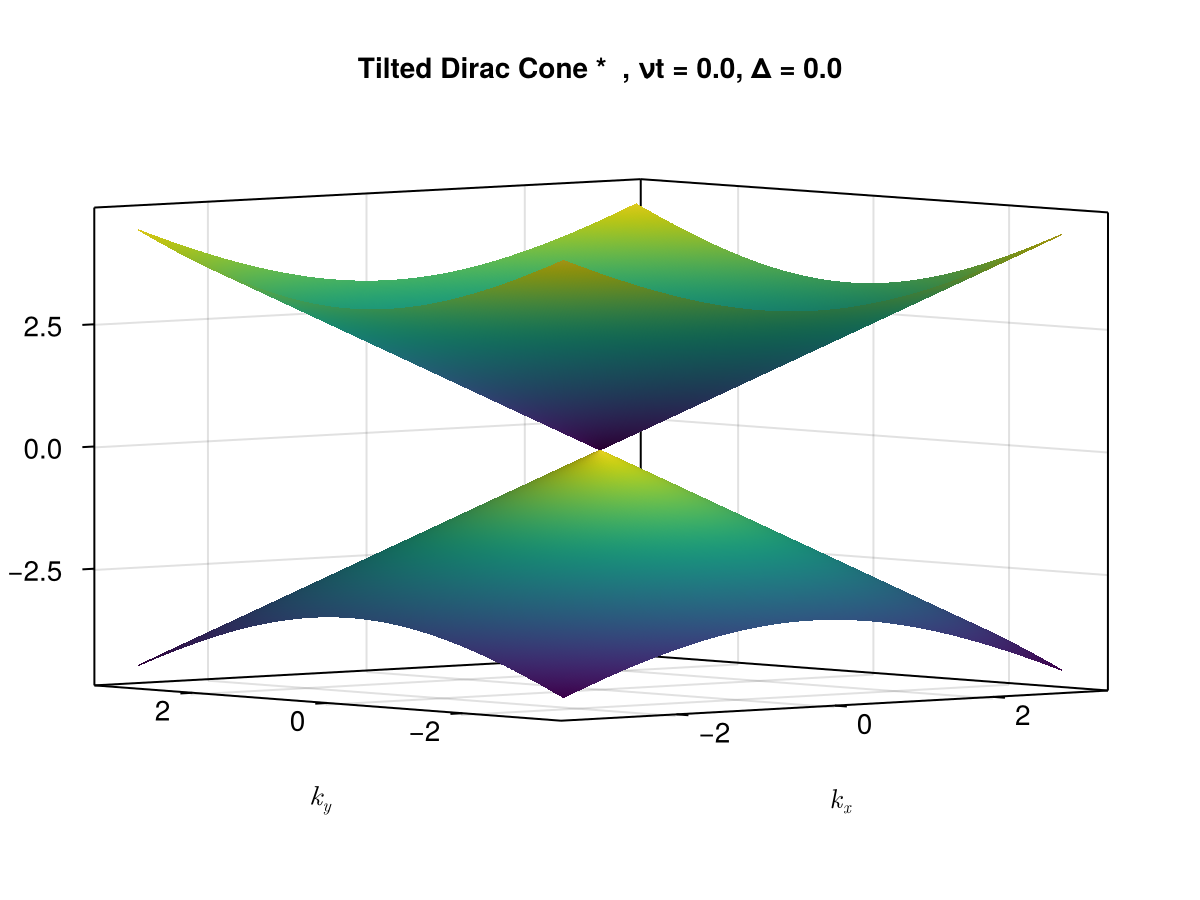

CairoMakie.Screen{IMAGE}


In [66]:
plot_bands3D(νt = 0.0, Δ = 0.0)

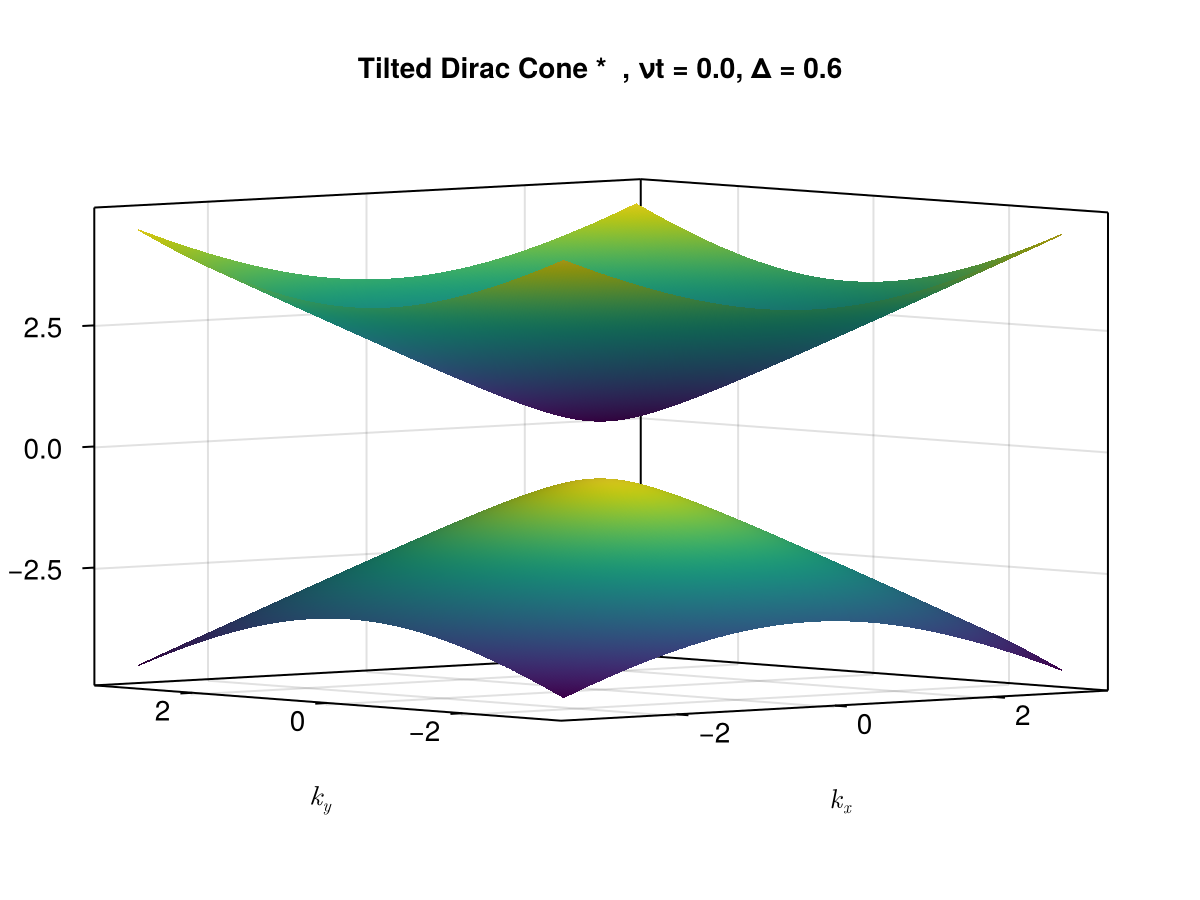

CairoMakie.Screen{IMAGE}


In [67]:
plot_bands3D(νt = 0.0, Δ = 0.6)

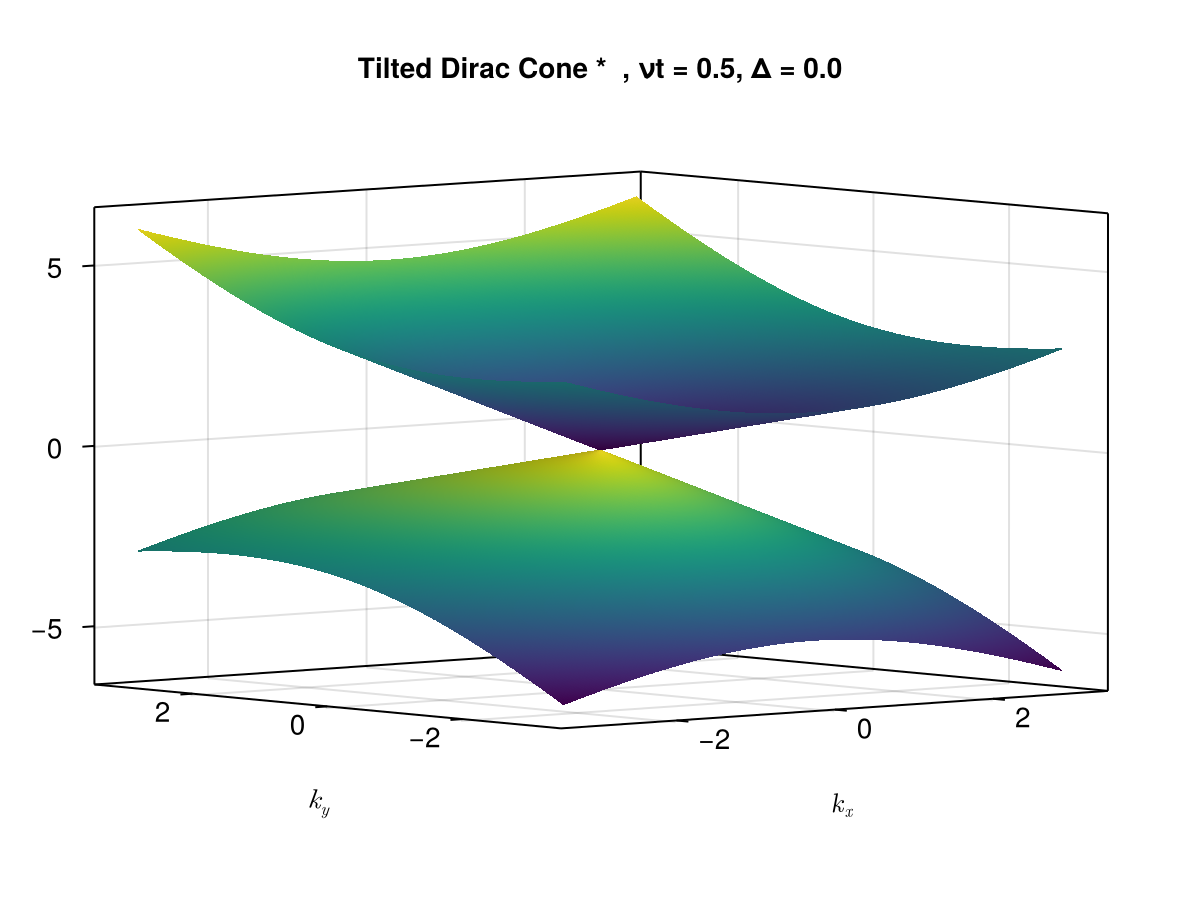

CairoMakie.Screen{IMAGE}


In [25]:
plot_bands3D(νt = 0.5, Δ = 0.0)

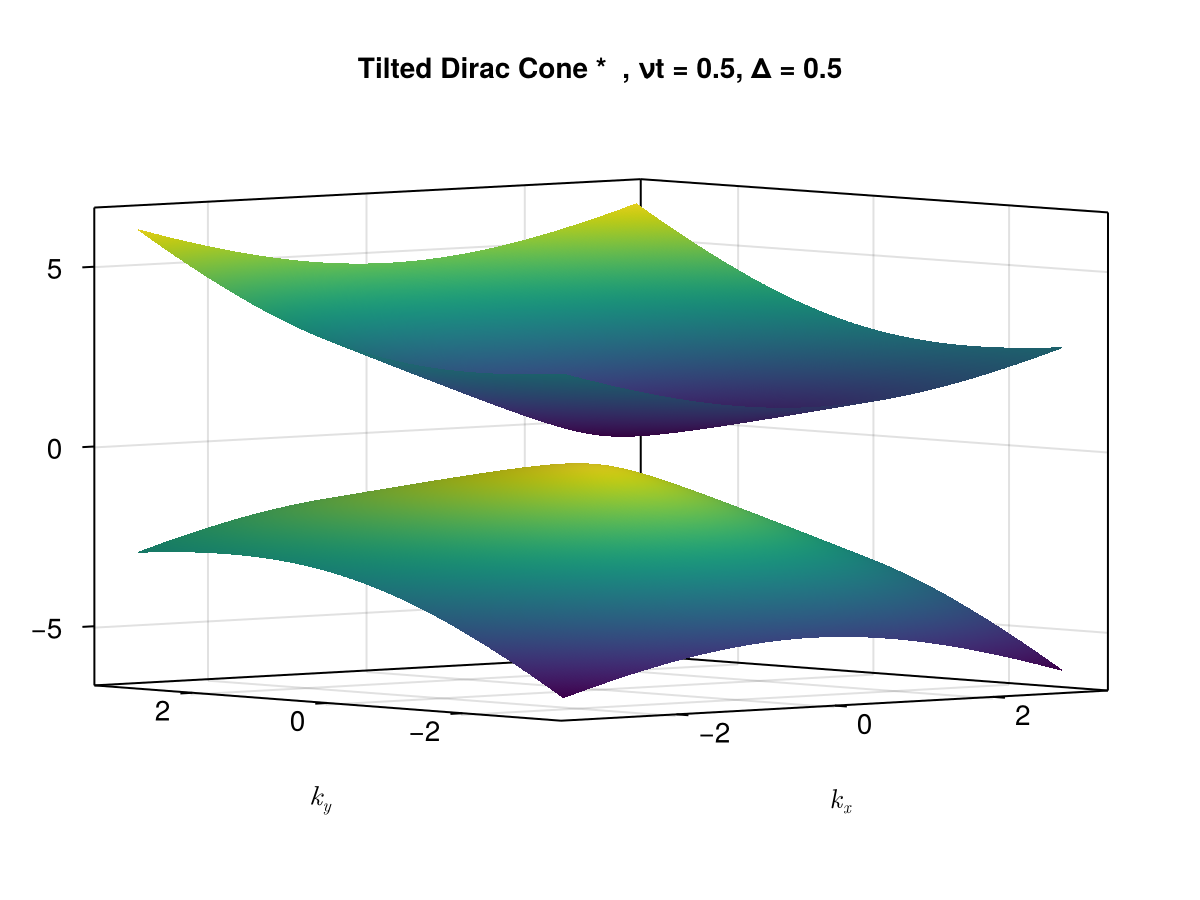

CairoMakie.Screen{IMAGE}


In [68]:
plot_bands3D(νt = 0.5, Δ = 0.5)

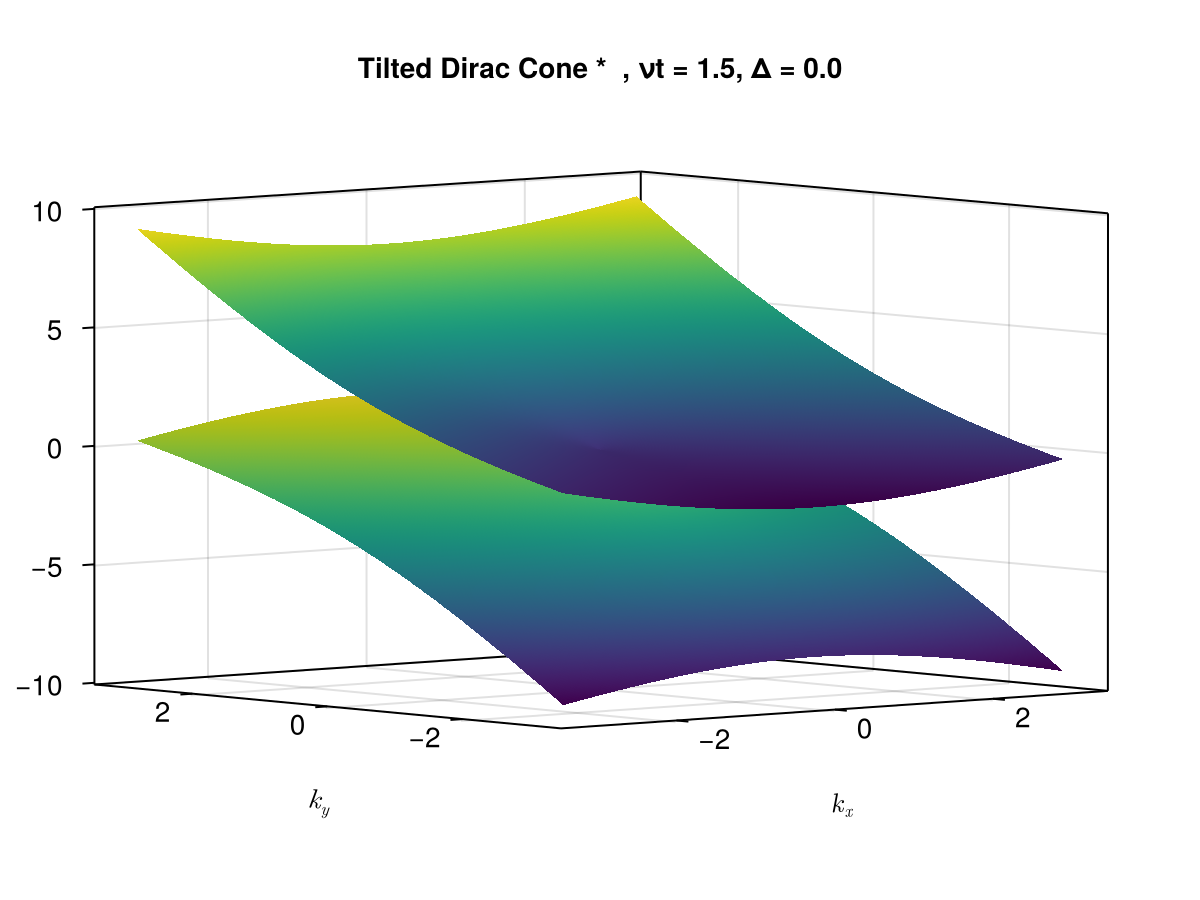

CairoMakie.Screen{IMAGE}


In [26]:
plot_bands3D(νt = 1.5, Δ = 0.0)

## Berry Curvature Polarizability Calculations (BCPH and BCPD)

In [180]:
@inline function QM_xy(k::Vector{Float64},
    νt::Float64, 
    Δ::Float64, 
    νF::Float64 = 1.0, 
    band::Int = 1)

    (E, U) = eigensystem_dirac_fermion(k, νt, Δ, νF)
    Vxb::Matrix{ComplexF64} = U' * Vx(k, νt, νF) * U
    Vyb::Matrix{ComplexF64} = U' * Vy(k, νt, νF) * U

    bck::Float64 = 0.0

    for n ∈ 1:2
        if (n != band)
            bck += real(Vxb[band, n] * Vyb[n, band]) / (E[band] - E[n])^2
        end
    end
    return bck
end



@inline function BRrenorm_QM(k::Vector{Float64},
    νt::Float64, 
    Δ::Float64,
    a::Int, 
    b::Int,
    νF::Float64 = 1.0
    )
    """
    Band-Renormalized Quantum Metric -- Related to Polarizability.  
    Input: 
        - parameters: νt, Δ
        - a, b: Spatial SO(2) Indices 
    Output: 
        - Gives a matrix in the band basis, here a 2 x 2 matrix connecting the different modes of the Dirac operator 
    """

    (E, U) = eigensystem_dirac_fermion(k, νt, Δ, νF)
    V_orb::Vector{Matrix{ComplexF64}} = V(νt, νF)
    Vmn::Vector{Matrix{ComplexF64}} = [U' * V_orb[1] * U, U' * V_orb[2] * U]

    ωmn::Matrix{Float64} = E' .- E
    ωmn[ωmn .== 0] .= Inf   # This will kill the diagonal terms 

    Xmn::Vector{Matrix{ComplexF64}} = [-im * Vmn[1] ./ ωmn, -im * Vmn[2] ./ ωmn]

    real.(transpose(Xmn)[a] .* Xmn[b] ./ ωmn)

end

## Differential of the Fermi-Dirac Distribution  
@inline function dFDm_dk(E::Float64, μ::Float64, TKelv::Float64)
    """
    Derivatives of the Fermi-Dirac Function -- Needed to construct Λ_BCPH and Λ_BCPD 
    """
end

@inline function FD(E::Float64, μ::Float64, TKelv::Float64)
    """
    The Fermi-Dirac Function -- Needed to construct Λ_BCPH and Λ_BCPD 
    """
    1.0 / (1.0 + exp((11604.518 / TKelv) * (E - μ)))
end


@inline function Λ_BCPH_fdiff_0Klv(k::Vector{Float64},
    νt::Float64,
    Δ::Float64,  
    a::Int, 
    b::Int, 
    c::Int,
    m::Int, 
    ϵ::Float64 = 1e-6,
    νF::Float64 = 1.0)
    """
    Berry Curvature Polarizability Hall Components -- Depends on the band index 
    Each Band has a Hall Polarizability and a 'Dissipative' Polarizability 
    This uses the finite difference numerical method 
    """
    Dk::Vector{Vector{Float64}} = [[ϵ, 0.0], [0.0, ϵ]]
    abc = (BRrenorm_QM(k + Dk[a], νt, Δ, b, c, νF) - BRrenorm_QM(k, νt, Δ, b, c, νF)) / ϵ
    bac = (BRrenorm_QM(k + Dk[b], νt, Δ, a, c, νF) - BRrenorm_QM(k, νt, Δ, a, c, νF)) / ϵ
    cab = (BRrenorm_QM(k + Dk[c], νt, Δ, a, b, νF) - BRrenorm_QM(k, νt, Δ, a, b, νF)) / ϵ
    res::Matrix{Float64} = 2.0 * abc - bac - cab
    sum(res[m, :])
end

@inline function Λ_BCPD_fdiff_0Klv(k::Vector{Float64},
    νt::Float64,
    Δ::Float64,  
    a::Int, 
    b::Int, 
    c::Int,
    m::Int, 
    ϵ::Float64 = 1e-6,
    νF::Float64 = 1.0)
    """
    Berry Curvature Polarizability Hall Components -- Depends on the band index 
    Each Band has a Hall Polarizability and a 'Dissipative' Polarizability 
    This uses the finite difference numerical method 
    """
    Dk::Vector{Vector{Float64}} = [[ϵ, 0.0], [0.0, ϵ]]
    abc = (BRrenorm_QM(k + Dk[a], νt, Δ, b, c, νF) - BRrenorm_QM(k, νt, Δ, b, c, νF)) / ϵ
    bac = (BRrenorm_QM(k + Dk[b], νt, Δ, a, c, νF) - BRrenorm_QM(k, νt, Δ, a, c, νF)) / ϵ
    cab = (BRrenorm_QM(k + Dk[c], νt, Δ, a, b, νF) - BRrenorm_QM(k, νt, Δ, a, b, νF)) / ϵ
    res::Matrix{Float64} = abc + bac + cab
    sum(res[m, :])
end


function Plot_Λ_BCPH_fdiff_0Klv(;
    νt::Float64,
    Δ::Float64,  
    a::Int, 
    b::Int, 
    c::Int,
    m::Int, 
    ϵ::Float64 = 1e-6,
    color_min::Float64 = -1000.0,
    color_max::Float64 = 1000.0,
    νF::Float64 = 1.0)
    """
    Berry Curvature Polarizability Hall Components integrated over momentum space 
    Each Band has a Hall Polarizability and a 'Dissipative' Polarizability 
    This uses the finite difference numerical method 
    """
    lim = 0.3; nps = 200

    map_num_xyz = Dict(1 => "x", 2 => "y")

    rng = LinRange(-lim, lim, nps)
    grid = Matrix{Vector{Float64}}(undef, nps, nps)
    for (n, kx) ∈ enumerate(rng)
        for (m, ky) ∈ enumerate(rng)
            grid[n, m] = [kx, ky]
        end
    end 

    Λvals::Matrix{Float64} = Λ_BCPH_fdiff_0Klv.(grid, Ref(νt), Ref(Δ), Ref(a), Ref(b), Ref(c), Ref(m), Ref(ϵ), Ref(νF))
    f = Figure()
    ax = Axis(f[1, 1], title = "ΛBCPH $(map_num_xyz[a])$(map_num_xyz[b])$(map_num_xyz[c]) for band $m")
    m = heatmap!(ax, Λvals, colormap = :bwr, colorrange = (color_min, color_max))
    Colorbar(f[1, 2], m)
    f

end

function Plot_Λ_BCPD_fdiff_0Klv(;
    νt::Float64,
    Δ::Float64,  
    a::Int, 
    b::Int, 
    c::Int,
    m::Int, 
    ϵ::Float64 = 1e-6,
    color_min::Float64 = -1000.0,
    color_max::Float64 = 1000.0,
    νF::Float64 = 1.0)
    """
    Berry Curvature Polarizability Hall Components integrated over momentum space 
    Each Band has a Hall Polarizability and a 'Dissipative' Polarizability 
    This uses the finite difference numerical method 
    """
    lim = 0.3; nps = 200

    map_num_xyz = Dict(1 => "x", 2 => "y")

    rng = LinRange(-lim, lim, nps)
    grid = Matrix{Vector{Float64}}(undef, nps, nps)
    for (n, kx) ∈ enumerate(rng)
        for (m, ky) ∈ enumerate(rng)
            grid[n, m] = [kx, ky]
        end
    end 

    Λvals::Matrix{Float64} = Λ_BCPD_fdiff_0Klv.(grid, Ref(νt), Ref(Δ), Ref(a), Ref(b), Ref(c), Ref(m), Ref(ϵ), Ref(νF))
    f = Figure()
    ax = Axis(f[1, 1], title = "ΛBCPD $(map_num_xyz[a])$(map_num_xyz[b])$(map_num_xyz[c]) for band $m")
    m = heatmap!(ax, Λvals, colormap = :bwr, colorrange = (color_min, color_max))
    Colorbar(f[1, 2], m)
    f

end



Plot_Λ_BCPD_fdiff_0Klv (generic function with 1 method)

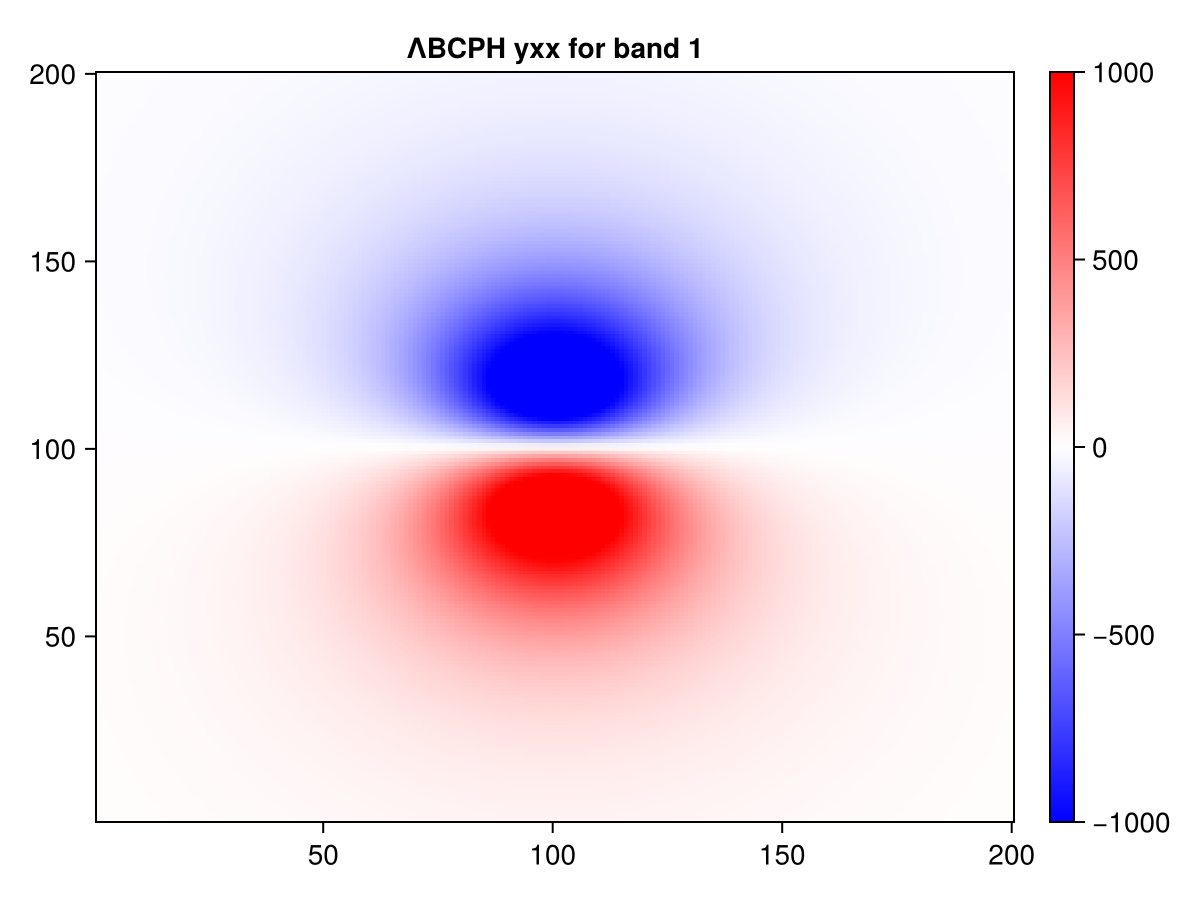

In [181]:
Plot_Λ_BCPH_fdiff_0Klv(νt = 0.1, Δ = 0.1, a = 2, b = 1, c = 1, m = 1, color_min = -1000.0, color_max = 1000.0)

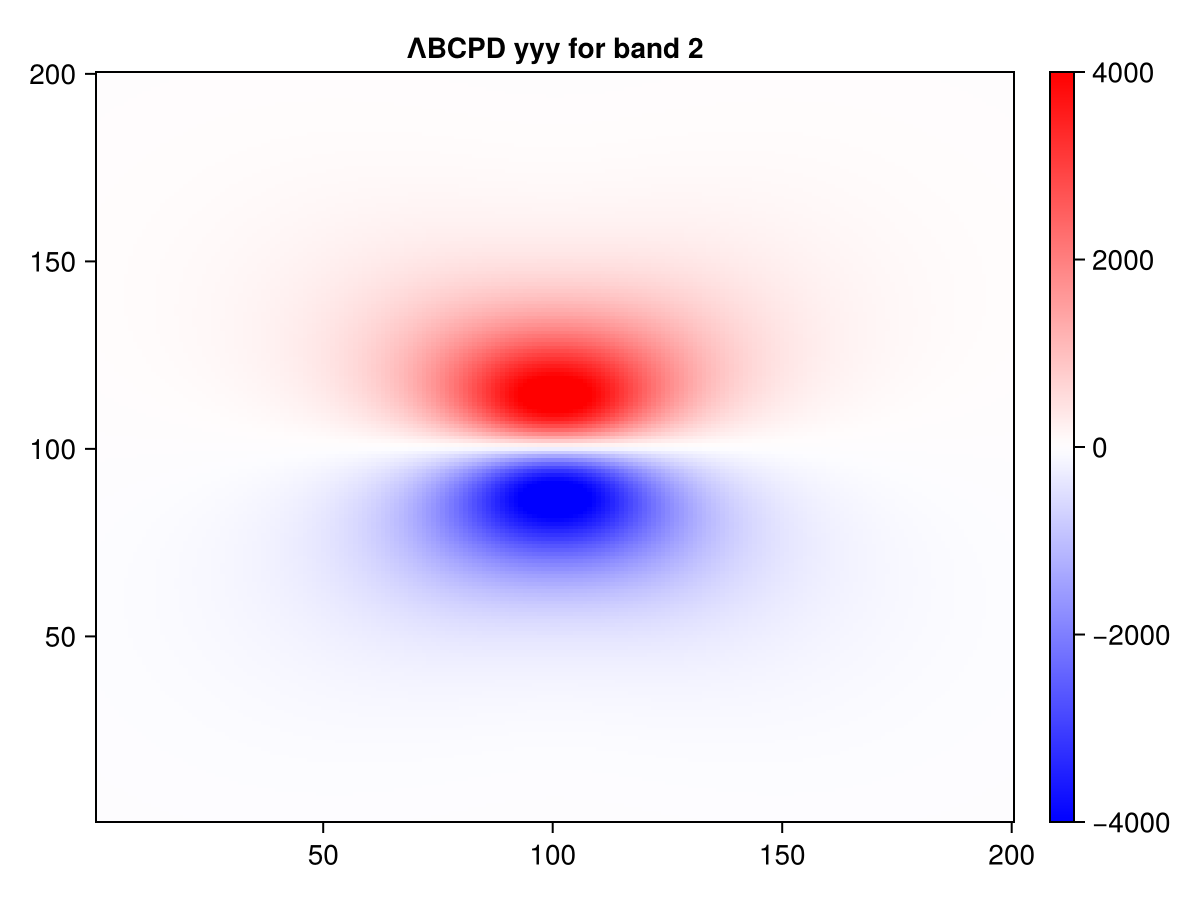

In [182]:
Plot_Λ_BCPD_fdiff_0Klv(νt = 0.1, Δ = 0.1, a = 2, b = 2, c = 2, m = 2, color_min = -4000.0, color_max = 4000.0)

## Calculation of the BCPH and BCPD Conductivities 